<a href="https://colab.research.google.com/github/05kashyap/AutoEncoded_Image_Transfer/blob/main/PgIC_AutoEncoder_256x.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset download

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aryankashyapnaveen","key":"aa9c642b29b1e110cc9813fa7f820dae"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset

 98% 737M/750M [00:09<00:00, 47.4MB/s]
100% 750M/750M [00:09<00:00, 79.4MB/s]


In [ ]:
!unzip '/content/stanford-dogs-dataset.zip'
#!rm -rf /content/stanford-dogs-dataset.zip

In [ ]:
import os

dataset_path = '/content/images/Images'

# List subdirectories (breeds)
breeds = os.listdir(dataset_path)
print("Number of breeds:", len(breeds))
print("Example breeds:", breeds[:5])

# List files in one breed (adjust as needed)
breed_path = os.path.join(dataset_path, breeds[0])
images_in_breed = os.listdir(breed_path)
print("Number of images in one breed:", len(images_in_breed))
print("Example images:", images_in_breed[:5])


Number of breeds: 120
Example breeds: ['n02107574-Greater_Swiss_Mountain_dog', 'n02112706-Brabancon_griffon', 'n02093256-Staffordshire_bullterrier', 'n02099601-golden_retriever', 'n02093991-Irish_terrier']
Number of images in one breed: 168
Example images: ['n02107574_1669.jpg', 'n02107574_1051.jpg', 'n02107574_1132.jpg', 'n02107574_225.jpg', 'n02107574_3289.jpg']


## Viewing a sample

In [ ]:
!pip install pytorch-msssim

size img(400, 500, 3)
size img(375, 500, 3)
size img(333, 500, 3)
size img(600, 450, 3)
size img(375, 500, 3)
size img(500, 495, 3)
size img(375, 500, 3)
size img(386, 325, 3)
size img(406, 610, 3)


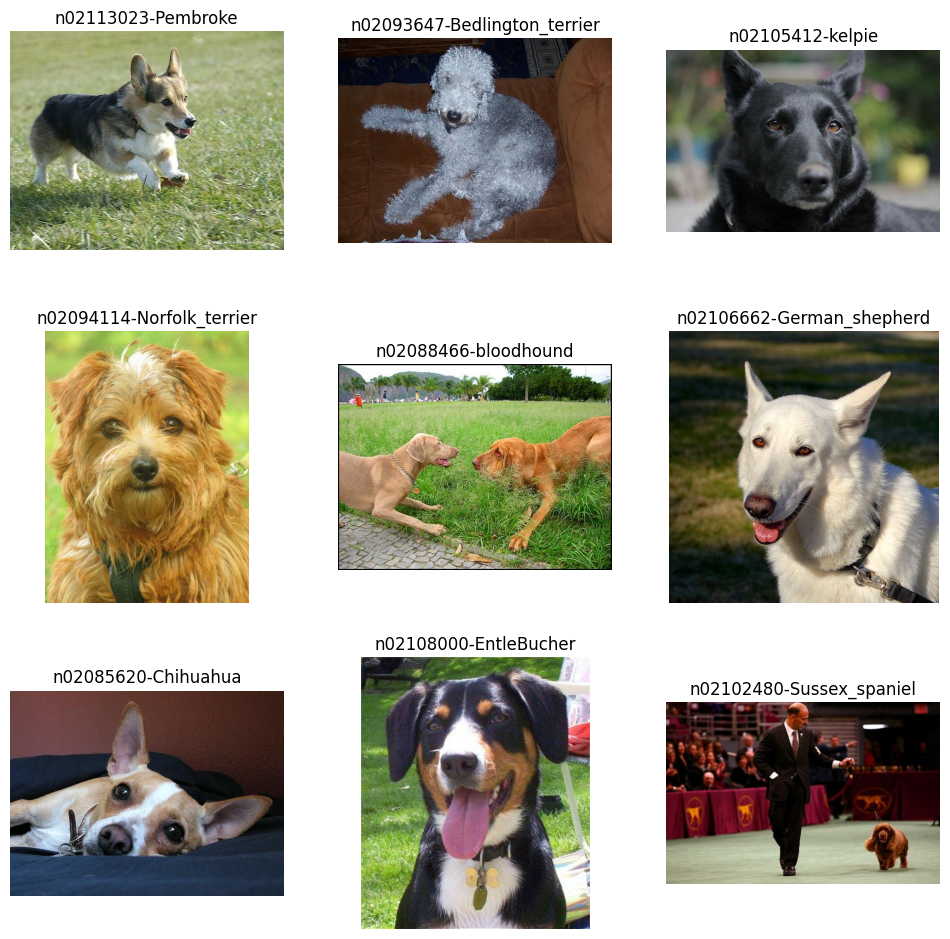

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random

# Visualize random images from different breeds
num_rows = 3
num_cols = 3

plt.figure(figsize=(12, 12))

for i in range(num_rows * num_cols):
    breed = random.choice(breeds)
    breed_path = os.path.join(dataset_path, breed)
    image_file = random.choice(os.listdir(breed_path))
    image_path = os.path.join(breed_path, image_file)

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(imread(image_path))
    print(f"size img{imread(image_path).shape}")
    plt.title(breed)
    plt.axis('off')

plt.show()

In [ ]:
import os
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

## Dataloader config

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image
import torch
import torch.nn.functional as F


transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Adjust the size as needed
    transforms.ToTensor(),
])
def collate_fn_padd(batch):
    '''
    Padds batch of variable length

    note: it converts things ToTensor manually here since the ToTensor transform
    assume it takes in images rather than arbitrary tensors.
    '''
    ## get sequence lengths
    lengths = torch.tensor([ t.shape[0] for t in batch ]).to(device)
    ## padd
    batch = [ torch.Tensor(t).to(device) for t in batch ]
    batch = torch.nn.utils.rnn.pad_sequence(batch)
    ## compute mask
    mask = (batch != 0).to(device)
    return batch, lengths, mask


dataset = ImageFolder(root=dataset_path, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 32 #set to 32 later
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=4)

test_loader = DataLoader(test_dataset, batch_size=16,
                         shuffle=False, num_workers=4)#look into collate fn

# Display batch
for images, targets in train_loader:
  print("Training Batch shape:", images.shape)
  break

Training Batch shape: torch.Size([32, 3, 256, 256])


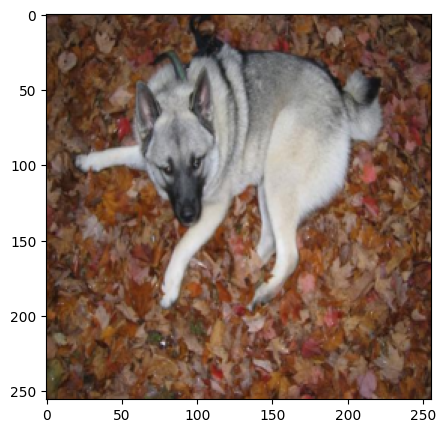

In [ ]:
import numpy as np

# obtain one batch of training images
for images, labels in train_loader:
    break  # Get the first batch only

images = images.numpy()

# get one image from the batch and transpose the axes
img = np.transpose(images[0], (1, 2, 0))

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.imshow(img)
plt.show()


# Building the network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")

GPU: Tesla T4


## Attention Module

In [ ]:
class AttentionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AttentionModule, self).__init__()

        # Convolutional layers to compute attention weights
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, 1, kernel_size=3, padding=1)

        # Softmax to obtain attention weights
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # Compute attention weights
        att = F.relu(self.conv1(x))
        att = self.conv2(att)
        att = self.softmax(att.view(att.size(0), -1)).view_as(att)

        # Multiply input by attention weights
        x = x * att

        return x

## Conv architecture

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(channels)
    self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(channels)

  def forward(self, x):
    residual = x
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += residual
    out = F.relu(out)
    return out

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bottleneck = nn.Conv2d(256, 64, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.bottleneck(x)
        return x

# Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(64, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv5 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = F.relu(self.deconv4(x))
        x = torch.sigmoid(self.deconv5(x))
        return x

# Progressive Image Compression
class ProgressiveAutoEncoder(nn.Module):
    def __init__(self):
        super(ProgressiveAutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        # Encode the input image
        encoded = self.encoder(x)

        # Progressive decoding
        decoded = self.decoder(encoded)
        residual = x - decoded
        return decoded, residual

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ProgressiveAutoEncoder()
#model = model.to(device)
print(model)

ProgressiveAutoEncoder(
  (encoder): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bottleneck): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (decoder): Decoder(
    (deconv1): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (deconv2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (deconv3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (deconv4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (deconv5): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 

## Model Training

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
train_losses = []
for epoch in range(num_epochs):
  running_loss = 0.0
  for data in train_loader:
    images, _ = data
    images = images.to(device)

    decoded, residual = model(images)

    reconstruction_loss = criterion(decoded, images)
    residual_loss = criterion(residual, torch.zeros_like(residual))
    loss = reconstruction_loss + residual_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  epoch_loss = running_loss / len(train_loader)
  train_losses.append(epoch_loss)

  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [1/50], Loss: 0.002055
Epoch [2/50], Loss: 0.003197
Epoch [3/50], Loss: 0.002496
Epoch [4/50], Loss: 0.002553
Epoch [5/50], Loss: 0.002185
Epoch [6/50], Loss: 0.002248
Epoch [7/50], Loss: 0.001646
Epoch [8/50], Loss: 0.001783
Epoch [9/50], Loss: 0.001524
Epoch [10/50], Loss: 0.002627
Epoch [11/50], Loss: 0.001643
Epoch [12/50], Loss: 0.002970
Epoch [13/50], Loss: 0.001788
Epoch [14/50], Loss: 0.002029
Epoch [15/50], Loss: 0.001791
Epoch [16/50], Loss: 0.002214
Epoch [17/50], Loss: 0.001923
Epoch [18/50], Loss: 0.002194
Epoch [19/50], Loss: 0.001788
Epoch [20/50], Loss: 0.002397
Epoch [21/50], Loss: 0.003037
Epoch [22/50], Loss: 0.002384
Epoch [23/50], Loss: 0.001450
Epoch [24/50], Loss: 0.002159
Epoch [25/50], Loss: 0.002225
Epoch [26/50], Loss: 0.001146
Epoch [27/50], Loss: 0.002373
Epoch [28/50], Loss: 0.001572
Epoch [29/50], Loss: 0.001874
Epoch [30/50], Loss: 0.002259
Epoch [31/50], Loss: 0.002593
Epoch [32/50], Loss: 0.002247
Epoch [33/50], Loss: 0.002349
Epoch [34/50], Loss

### Plotting the loss

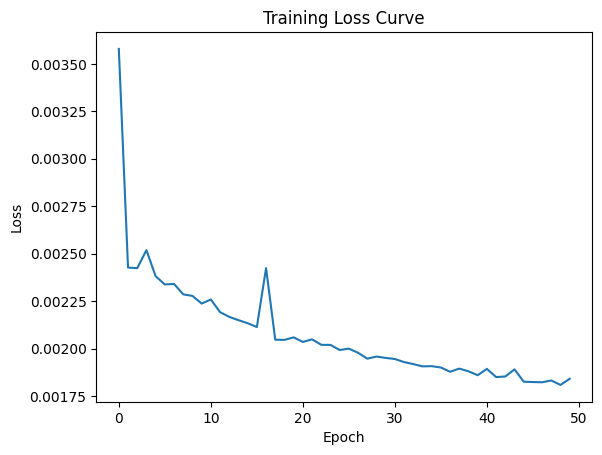

In [ ]:
plt.figure()
plt.plot(range(num_epochs), train_losses)
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Saving the encoder and decoder weights separately

In [ ]:
torch.save(model.encoder.state_dict(), 'prog_encoder_256x_50e.pth')
torch.save(model.decoder.state_dict(), 'prog_decoder_256x_50e.pth')

# Using the encoder-decoder

## Load the models (switch to GPU later)

In [ ]:
encoder = Encoder()
encoder.load_state_dict(torch.load('prog_encoder_256x_50e.pth',map_location=torch.device('cpu')))
encoder.eval()

decoder = Decoder()
decoder.load_state_dict(torch.load('prog_decoder_256x_50e.pth',map_location=torch.device('cpu')))
decoder.eval()

Decoder(
  (deconv1): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv5): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
from torchvision.utils import make_grid

In [ ]:
import time
timings = []

## Plotting the images, reconstructions and latent spaces

1.5069584846496582
compressed_size: torch.Size([16, 64, 16, 16])


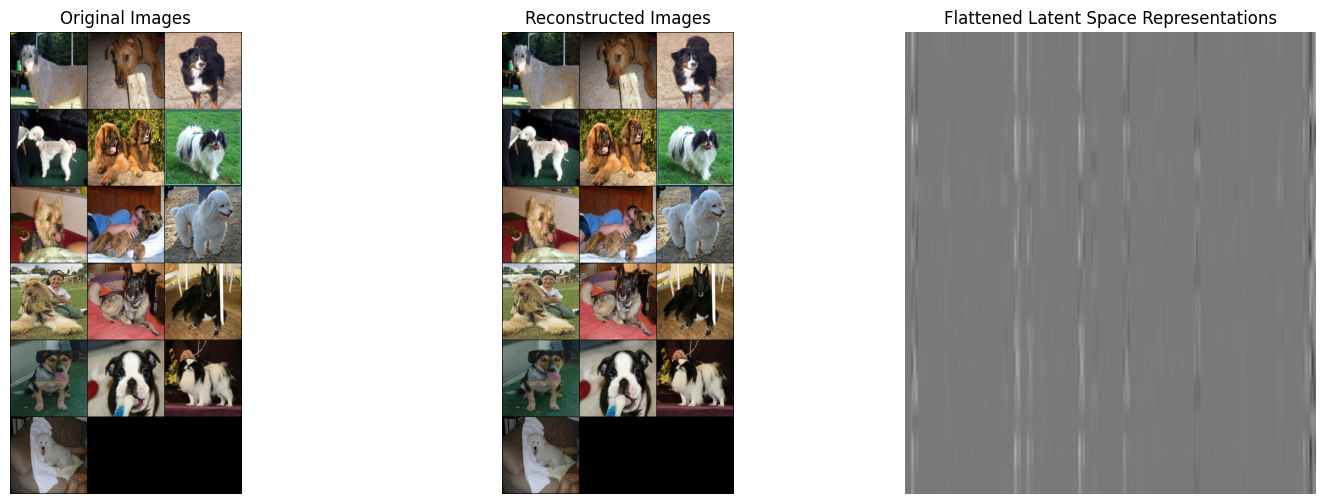

In [ ]:
test_images, _ = next(iter(test_loader))

start_time = time.time()
compressed_representations = encoder(test_images)
reconstructed_images = decoder(compressed_representations)
end_time = time.time()
print(end_time - start_time)
print("compressed_size:", compressed_representations.shape)
# Flatten the latent space representations
flattened_latent = compressed_representations.detach().view(compressed_representations.size(0), -1)

# Create a grid of original, reconstructed, and latent space images
original_grid = make_grid(test_images, nrow=3, normalize=True)
reconstructed_grid = make_grid(reconstructed_images, nrow=3, normalize=True)

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(np.transpose(original_grid.numpy(), (1, 2, 0)))
ax[0].set_title('Original Images')
ax[0].axis('off')

ax[1].imshow(np.transpose(reconstructed_grid.numpy(), (1, 2, 0)))
ax[1].set_title('Reconstructed Images')
ax[1].axis('off')

ax[2].imshow(flattened_latent.numpy(), cmap='gray', aspect='auto')
ax[2].set_title('Flattened Latent Space Representations')
ax[2].axis('off')

plt.show()

In [ ]:
from skimage.metrics import structural_similarity as ssim

## Plotting the SSIMs of images over a batch of 16 samples from the test loader

<ipython-input-47-b8cfc76cab86>:5: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_val = ssim(orig_img_np, recon_img_np, data_range=1.0, multichannel=True)


0.8956972
0.84767073
0.92226857
0.934925
0.88520294
0.8036418
0.9183863
0.89949304
0.8570924
0.8926466
0.9074629
0.88606423
0.93516684
0.9666772
0.95995194
0.95356554


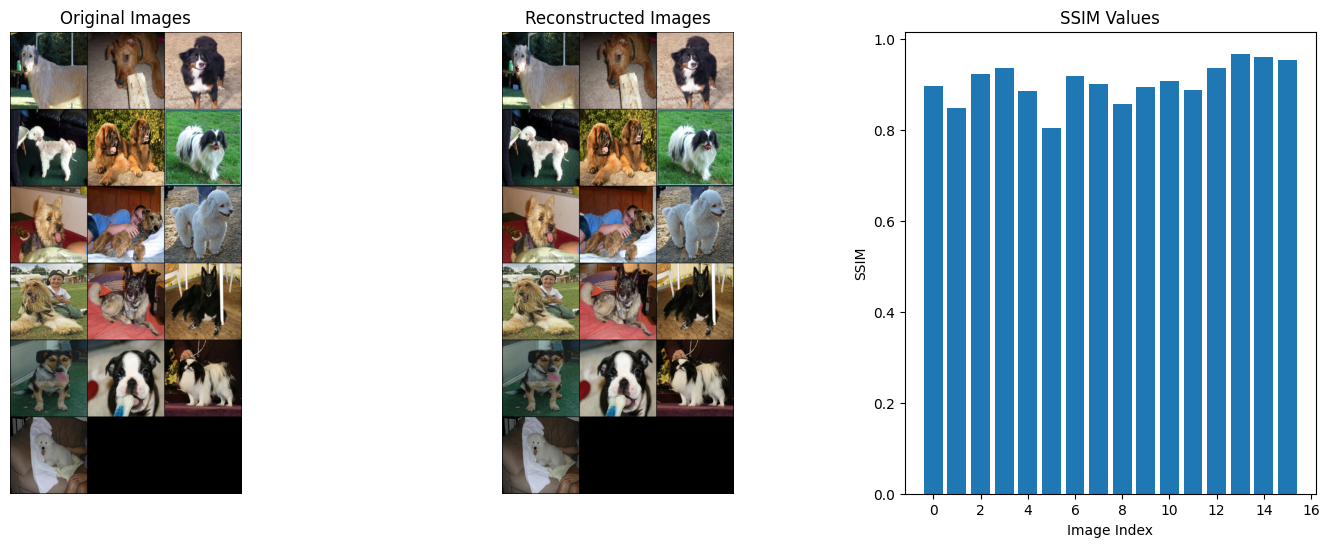

In [ ]:
ssim_values = []
for orig_img, recon_img in zip(test_images, reconstructed_images):
    orig_img_np = orig_img.permute(1, 2, 0).detach().cpu().numpy()
    recon_img_np = recon_img.permute(1, 2, 0).detach().cpu().numpy()
    ssim_val = ssim(orig_img_np, recon_img_np, data_range=1.0, multichannel=True)
    print(ssim_val)
    ssim_values.append(ssim_val)

# Create a grid of original and reconstructed images
original_grid = make_grid(test_images, nrow=3, normalize=True)
reconstructed_grid = make_grid(reconstructed_images, nrow=3, normalize=True)

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(np.transpose(original_grid.numpy(), (1, 2, 0)))
ax[0].set_title('Original Images')
ax[0].axis('off')

ax[1].imshow(np.transpose(reconstructed_grid.numpy(), (1, 2, 0)))
ax[1].set_title('Reconstructed Images')
ax[1].axis('off')

ax[2].bar(range(len(ssim_values)), ssim_values)
ax[2].set_title('SSIM Values')
ax[2].set_xlabel('Image Index')
ax[2].set_ylabel('SSIM')

plt.show()

In [ ]:
s = 0
for i in ssim_values:
  s += i
print(s/len(ssim_values))

0.904119573533535


### Average 0.904 SSIM